# 0. Indice
## 0.1 Entorno y GPU
# 1. Datos (KDD99) y preprocesamiento
## 1.1 Descarga KDD99 10%
## 1.2 Carga, limpieza y CSV limpio
## 1.3 Split multiclase (70/15/15) + escalado
## 1.4 Distribución de clases (gráfica)
# 2. Red neuronal FCN (PyTorch)
## 2.1 Dataset & DataLoader (train/val/test)
## 2.2 Arquitectura FCN (4 capas, ReLU, softmax)
## 2.3 Entrenamiento `train_fcn` + Optuna (lr)
## 2.4 Variantes de arquitectura (≥3) y curvas
## 2.5 Evaluación `evaluate_fcn`: accuracy, F1 macro, matriz
## 2.6 10 corridas por modelo (media ± desviación)
## 2.7 Pesado por clases en la pérdida (class weights)
# 3. Comparativa y discusión final


# 0. Iniciar
## 0.1 Entorno y GPU
**Objetivo:** Preparar el entorno: instalar librerías, fijar semillas para reproducibilidad, montar Drive y crear la estructura de carpetas del proyecto. También detectar si hay GPU disponible.


In [1]:



!pip -q install optuna pytorch-tabnet imbalanced-learn


import os, random
import numpy as np
import torch
import sklearn
import optuna
import pytorch_tabnet
import importlib.metadata

print("torch:", torch.__version__)
print("sklearn:", sklearn.__version__)
print("optuna:", optuna.__version__)
#print("tabnet:", pytorch_tabnet.__version__)
print("tabnet:", importlib.metadata.version("pytorch-tabnet"))
# Semillas fijas para resultados replicables
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# En algunos entornos, los algoritmos deterministas pueden advertir:
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception as e:
    print("Nota determinismo:", e)

# 4) Montar Google Drive para guardar datos/modelos/figuras
from google.colab import drive
drive.mount('/content/drive')

# 5) Estructura mínima de carpetas dentro de tu Drive (no pisa nada existente)
#    Si ya tenés una estructura del TP1, en el Paso 2 podemos apuntar a esa.
from pathlib import Path
BASE = Path('/content/drive/MyDrive/TEC_AD_TP2')
for d in ['data', 'src', 'notebooks', 'figures', 'models', 'reports', 'docs']:
    (BASE / d).mkdir(parents=True, exist_ok=True)

# 6) Crear archivos marcador (útil para GitHub y orden)
for d in ['data', 'src', 'notebooks', 'figures', 'models', 'reports', 'docs']:
    marker = BASE / d / '.keep'
    if not marker.exists():
        marker.write_text('')

print("Estructura creada en:", BASE.resolve())

# 7) (Opcional) Verificar si tenemos GPU disponible (solo informativo)
gpu = torch.cuda.is_available()
print("GPU disponible:", gpu)




torch: 2.8.0+cu126
sklearn: 1.6.1
optuna: 4.5.0
tabnet: 4.1.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Estructura creada en: /content/drive/MyDrive/TEC_AD_TP2
GPU disponible: True


## 0.2 Detección de GPU
**Objetivo:** Verificar si se está usando GPU o CPU.  
Si no hay GPU, se muestra un recordatorio para activarla en *Entorno de ejecución > Cambiar tipo de entorno de ejecución > GPU*.


In [2]:
# ==== DETECCIÓN Y USO DE GPU ====
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo en uso:", device)

# Si no hay GPU, mostrar recordatorio
if device.type == "cpu":
    print("⚠️ Nota: Estás corriendo en CPU. Para acelerar el entrenamiento, "
          "ve a 'Entorno de ejecución > Cambiar tipo de entorno de ejecución > GPU'")

Dispositivo en uso: cuda


## 1.1 Descarga KDD99 10%
**Objetivo:** Descargar el dataset KDD Cup 1999 en su versión reducida al 10%  
(`kddcup.data_10_percent.gz`) desde la página oficial de UCI, y guardarlo en la carpeta `data/`.  
Se descarga solo si no existe localmente, y se verifica el tamaño del archivo (~4–5 MB).


In [3]:
# ==== DESCARGA KDD99 (10%) A /data ====
# Objetivo: traer el archivo original comprimido (gz) a la carpeta data del proyecto.

from pathlib import Path
import os

BASE = Path('/content/drive/MyDrive/TEC_AD_TP2')  # misma ruta del PASO 1
DATA_DIR = BASE / 'data'
RAW_GZ = DATA_DIR / 'kddcup.data_10_percent.gz'

# 1) URL oficial (copia de UCI/Stat)
URL = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'

# 2) Descargar solo si no existe (evita descargas repetidas)
if not RAW_GZ.exists():
    print("Descargando dataset 10% KDD99...")
    # Usamos wget por simplicidad en Colab
    !wget -q -O "$RAW_GZ" "$URL"
    assert RAW_GZ.exists(), "No se descargó el archivo. Revisa tu conexión o la URL."
    print("Descarga completa:", RAW_GZ)
else:
    print("Archivo ya existe:", RAW_GZ)

# 3) Verificamos tamaño aproximado (debería ser ~4.5MB)
size_mb = os.path.getsize(RAW_GZ) / (1024 * 1024)
print(f"Tamaño del archivo: {size_mb:.2f} MB (esperado ~4-5MB)")


Archivo ya existe: /content/drive/MyDrive/TEC_AD_TP2/data/kddcup.data_10_percent.gz
Tamaño del archivo: 2.05 MB (esperado ~4-5MB)


## 1.2 Carga, limpieza y CSV limpio
**Objetivo:** Leer el archivo comprimido del dataset KDD99, asignar nombres correctos a las columnas, normalizar la etiqueta `label`, crear una versión binaria (`normal` vs `attack`) y guardar un CSV limpio para uso posterior.  
Se incluye un conteo de clases en su versión multiclase original y en la binaria, para verificar la distribución inicial.


In [4]:
# ==== CARGA, NOMBRES DE COLUMNAS, INSPECCIÓN Y CSV LIMPIO ====
import pandas as pd
from pathlib import Path

BASE = Path('/content/drive/MyDrive/TEC_AD_TP2')
DATA_DIR = BASE / 'data'
RAW_GZ = DATA_DIR / 'kddcup.data_10_percent.gz'

# 1) Definimos los nombres de las columnas según KDD99 (41 features + label)
#    El archivo 10% clásico puede o no traer la columna 'difficulty'. La detectamos luego.
colnames_base = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent",
    "hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login",
    "is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
    "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
    "dst_host_srv_rerror_rate","label"
]

# 2) Leemos el .gz sin descomprimir manualmente (pandas lo maneja)
df = pd.read_csv(RAW_GZ, header=None, names=None)

# 3) Asignamos nombres según el número de columnas detectadas
if df.shape[1] == 42:
    # 41 features + label
    df.columns = colnames_base
elif df.shape[1] == 43:
    # 41 features + label + difficulty (algunos espejos lo incluyen)
    df.columns = colnames_base + ["difficulty"]
else:
    raise ValueError(f"Número de columnas inesperado: {df.shape[1]}")

print("Dimensiones:", df.shape)
print("Primeras filas:")
display(df.head())

# 4) Normalización básica del label (remover espacios y asegurar minúsculas)
df['label'] = df['label'].astype(str).str.strip().str.lower()

# 5) Mapa binario: normal vs ataque (todo lo que no sea 'normal' lo marcamos como 'attack')
df['label_binary'] = df['label'].apply(lambda x: 'normal' if x == 'normal' else 'attack')

# 6) Conteo de clases (multi-clase original y binario)
print("\nClases (multiclase) top 10:")
display(df['label'].value_counts().head(10))

print("\nClases (binario):")
display(df['label_binary'].value_counts())

# 7) Guardar CSV “limpio” (sin tocar aún las categóricas)
CLEAN_CSV = DATA_DIR / 'kdd99_10pct_clean.csv'
df.to_csv(CLEAN_CSV, index=False)
print("\nCSV limpio guardado en:", CLEAN_CSV.resolve())


Dimensiones: (494021, 42)
Primeras filas:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.



Clases (multiclase) top 10:


,count
label,
smurf.,280790
neptune.,107201
normal.,97278
back.,2203
satan.,1589
ipsweep.,1247
portsweep.,1040
warezclient.,1020
teardrop.,979



Clases (binario):


,count
label_binary,
attack,494021



CSV limpio guardado en: /content/drive/MyDrive/TEC_AD_TP2/data/kdd99_10pct_clean.csv


## 1.3 Split multiclase (70/15/15) + escalado
**Objetivo:** Dividir el dataset en conjuntos de entrenamiento (70%), validación (15%) y prueba (15%), respetando lo más posible la distribución de clases (estratificación).  
Se incluye una estrategia especial para manejar clases con muy pocas instancias (singletons), asignándolas directamente al conjunto de prueba para no perderlas.  
El resultado son tres subconjuntos equilibrados y listos para aplicar escalado de características.


In [5]:
# ==== 1.3 SPLIT MULTICLASE (70/15/15) + ESCALADO ====
# Objetivo:
# - Preparar X (features) e y (label multiclase) desde el CSV limpio.
# - One-hot de categóricas (protocol_type, service, flag).
# - Split robusto 70/15/15, respetando lo más posible la estratificación:
#   * Si en el conjunto temporal aparecen clases con 1 sola muestra (singletons),
#     se envían completas a TEST y el resto se divide 50/50 en VAL/TEST.
# - Escalar SOLO las columnas numéricas (fit en train, transform en val/test).
# - Reconstruir matrices finales [num_scaled || one-hot], alinear columnas y guardar CSVs.
# - Guardar el StandardScaler para reproducibilidad.

from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# ---------- RUTAS ----------
BASE = Path('/content/drive/MyDrive/TEC_AD_TP2')
DATA_DIR = BASE / 'data'
CLEAN_CSV = DATA_DIR / 'kdd99_10pct_clean.csv'  # generado en 1.2

# ---------- CARGA Y DEFINICIONES ----------
df = pd.read_csv(CLEAN_CSV)

# Columnas categóricas originales (se codifican con one-hot)
cat_cols = ['protocol_type', 'service', 'flag']

# Lista de las 41 features de KDD99 (sin 'label'); luego derivamos numéricas = todas menos las categóricas
base_cols = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent",
    "hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login",
    "is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
    "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
    "dst_host_srv_rerror_rate"
]
label_col = 'label'  # MULTICLASE

# Numéricas originales = todas las base menos las categóricas
num_cols = [c for c in base_cols if c not in cat_cols]

# ---------- CONSTRUIR X, y ----------
X_raw = df[base_cols].copy()
y = df[label_col].astype(str).str.strip().str.lower()

# One-hot de categóricas (se hace sobre todo el dataset; no fuga info del target)
X_cat = pd.get_dummies(X_raw[cat_cols], prefix=cat_cols)
X_num = X_raw[num_cols].copy()

# ---------- SPLIT PRINCIPAL 70/30 ESTRATIFICADO ----------
X_num_train, X_num_temp, X_cat_train, X_cat_temp, y_train, y_temp = train_test_split(
    X_num, X_cat, y, test_size=0.30, random_state=42, stratify=y
)

# ---------- MANEJO DE CLASES SINGLETON EN TEMP ----------
counts_temp = y_temp.value_counts()
singleton_classes = set(counts_temp[counts_temp == 1].index)

is_singleton = y_temp.isin(singleton_classes)

# a) Singletons -> TEST directo
X_num_single = X_num_temp[is_singleton].copy()
X_cat_single = X_cat_temp[is_singleton].copy()
y_single     = y_temp[is_singleton].copy()

# b) Resto (>=2 por clase) -> split 50/50 para VAL/TEST_PARCIAL
X_num_rest = X_num_temp[~is_singleton].copy()
X_cat_rest = X_cat_temp[~is_singleton].copy()
y_rest     = y_temp[~is_singleton].copy()

if len(y_rest) > 0:
    try:
        # Intento estratificado
        Xn_val, Xn_test_p, Xc_val, Xc_test_p, y_val, y_test_p = train_test_split(
            X_num_rest, X_cat_rest, y_rest, test_size=0.50, random_state=42, stratify=y_rest
        )
    except ValueError:
        # Fallback: sin estratificación, mantiene proporciones aprox. por mezcla aleatoria reproducible
        Xn_val, Xn_test_p, Xc_val, Xc_test_p, y_val, y_test_p = train_test_split(
            X_num_rest, X_cat_rest, y_rest, test_size=0.50, random_state=42, shuffle=True
        )
else:
    # Caso extremo: todo temp eran singletons
    Xn_val = X_num_rest.iloc[:0].copy()
    Xc_val = X_cat_rest.iloc[:0].copy()
    y_val  = y_rest.iloc[:0].copy()
    Xn_test_p = X_num_rest.iloc[:0].copy()
    Xc_test_p = X_cat_rest.iloc[:0].copy()
    y_test_p  = y_rest.iloc[:0].copy()

# c) TEST final = test_parcial + singletons
X_num_test = pd.concat([Xn_test_p, X_num_single], axis=0)
X_cat_test = pd.concat([Xc_test_p, X_cat_single], axis=0)
y_test     = pd.concat([y_test_p,   y_single], axis=0)

# ---------- ESCALADO DE NUMÉRICAS (fit en train) ----------
scaler = StandardScaler(with_mean=True, with_std=True)
X_num_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_num_train),
    columns=X_num_train.columns, index=X_num_train.index
)
X_num_val_scaled = pd.DataFrame(
    scaler.transform(Xn_val),
    columns=Xn_val.columns, index=Xn_val.index
)
X_num_test_scaled = pd.DataFrame(
    scaler.transform(X_num_test),
    columns=X_num_test.columns, index=X_num_test.index
)

# ---------- RECONSTRUIR MATRICES: [num_scaled || one-hot] ----------
X_train = pd.concat([X_num_train_scaled, X_cat_train.reset_index(drop=True)], axis=1)
X_val   = pd.concat([X_num_val_scaled,   Xc_val.reset_index(drop=True)],   axis=1)
X_test  = pd.concat([X_num_test_scaled,  X_cat_test.reset_index(drop=True)],  axis=1)

# Alinear columnas por seguridad (en caso de dummies raras faltantes en algún split)
all_cols = sorted(list(set(X_train.columns) | set(X_val.columns) | set(X_test.columns)))
X_train = X_train.reindex(columns=all_cols, fill_value=0)
X_val   = X_val.reindex(columns=all_cols,   fill_value=0)
X_test  = X_test.reindex(columns=all_cols,  fill_value=0)

# ---------- IMPRESIONES DE CONTROL ----------
n_train, n_val, n_test = len(y_train), len(y_val), len(y_test)
total = n_train + n_val + n_test
print(f"Tamaños (y): train={n_train}  val={n_val}  test={n_test}")
print("Proporciones -> train: {:.1%} | val: {:.1%} | test: {:.1%}".format(n_train/total, n_val/total, n_test/total))
print("Clases únicas -> val:", y_val.nunique(), "| test:", y_test.nunique())
print("Singletons enviados a test:", len(y_single))

# ---------- GUARDADO DE CSVs MULTICLASE ----------
mc_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True).rename('label')], axis=1)
mc_val   = pd.concat([X_val.reset_index(drop=True),   y_val.reset_index(drop=True).rename('label')],   axis=1)
mc_test  = pd.concat([X_test.reset_index(drop=True),  y_test.reset_index(drop=True).rename('label')],  axis=1)

mc_train_path = DATA_DIR / 'kdd99_mc_train.csv'
mc_val_path   = DATA_DIR / 'kdd99_mc_val.csv'
mc_test_path  = DATA_DIR / 'kdd99_mc_test.csv'

mc_train.to_csv(mc_train_path, index=False)
mc_val.to_csv(mc_val_path, index=False)
mc_test.to_csv(mc_test_path, index=False)

# ---------- GUARDAR SCALER ----------
scaler_path = DATA_DIR / 'scaler_mc.joblib'
joblib.dump(scaler, scaler_path)

print("\nGuardados:")
print(" -", mc_train_path)
print(" -", mc_val_path)
print(" -", mc_test_path)
print(" -", scaler_path)



Tamaños (y): train=345814  val=74102  test=74105
Proporciones -> train: 70.0% | val: 15.0% | test: 15.0%
Clases únicas -> val: 20 | test: 23
Singletons enviados a test: 3

Guardados:
 - /content/drive/MyDrive/TEC_AD_TP2/data/kdd99_mc_train.csv
 - /content/drive/MyDrive/TEC_AD_TP2/data/kdd99_mc_val.csv
 - /content/drive/MyDrive/TEC_AD_TP2/data/kdd99_mc_test.csv
 - /content/drive/MyDrive/TEC_AD_TP2/data/scaler_mc.joblib


## 1.4 Distribución de clases (gráfica)
**Objetivo:** Visualizar la distribución de las clases más frecuentes en los conjuntos de entrenamiento, validación y prueba.  
La gráfica confirma que el dataset está fuertemente desbalanceado (por ejemplo, predominan `smurf.` y `neptune.`), lo cual justifica el uso posterior de técnicas de ponderación por clase en el entrenamiento de la red.


Figura guardada en: /content/drive/MyDrive/TEC_AD_TP2/figures/kdd99_multiclase_distribucion_top10.png


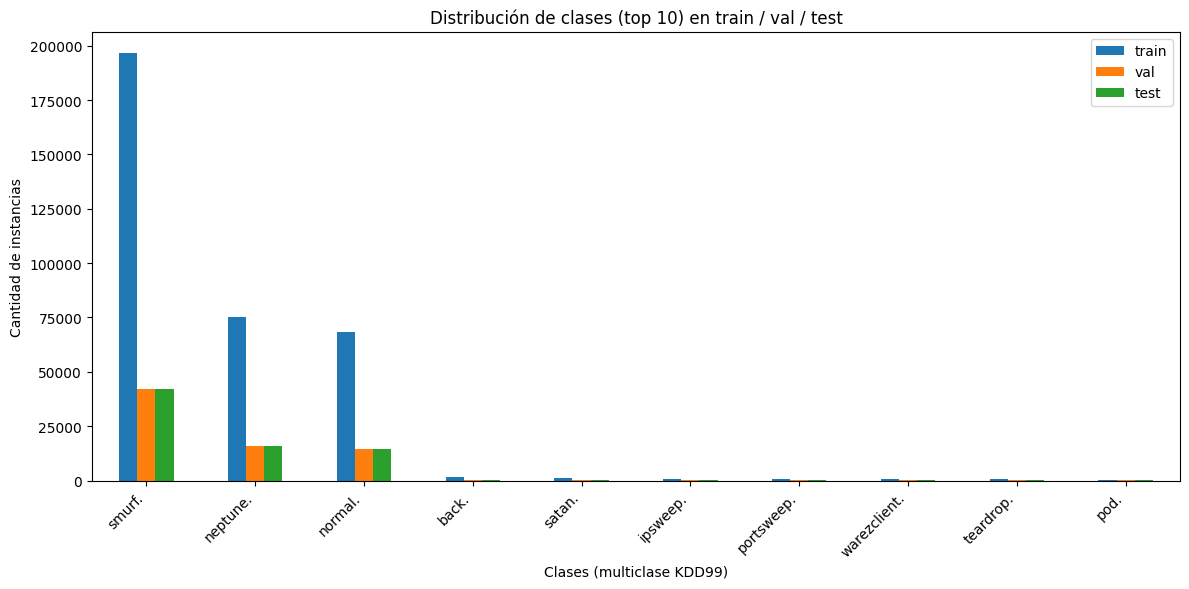

In [6]:
# ==== GRÁFICA: DISTRIBUCIÓN DE CLASES (TOP 10) EN TRAIN/VAL/TEST ====
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

BASE = Path('/content/drive/MyDrive/TEC_AD_TP2')
FIG_DIR = BASE / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Conteos por split (y_train, y_val, y_test ya existen del bloque anterior)
train_counts = y_train.value_counts()
val_counts   = y_val.value_counts()
test_counts  = y_test.value_counts()

# Unir en un DataFrame para comparación
dist_df = pd.DataFrame({
    "train": train_counts,
    "val": val_counts,
    "test": test_counts
}).fillna(0).astype(int)

# Tomar las 10 clases más frecuentes (ayuda a que la figura no sea inmensa)
top_classes = dist_df.sum(axis=1).sort_values(ascending=False).head(10).index
plot_df = dist_df.loc[top_classes].sort_values(by="train", ascending=False)

ax = plot_df.plot(kind="bar", figsize=(12,6))
ax.set_title("Distribución de clases (top 10) en train / val / test")
ax.set_ylabel("Cantidad de instancias")
ax.set_xlabel("Clases (multiclase KDD99)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Guardar para el informe LyX
out_path = FIG_DIR / "kdd99_multiclase_distribucion_top10.png"
plt.savefig(out_path, dpi=150)
print("Figura guardada en:", out_path)
plt.show()


# 2. Red neuronal FCN (PyTorch)
## 2.1 Dataset & DataLoader (train/val/test)
**Objetivo.** Preparar los conjuntos de entrenamiento/validación/prueba para PyTorch a partir de los CSV preprocesados (multiclase), mapeando cada etiqueta textual a un índice entero estable y creando `DataLoader` con batching.

**Entradas.** `data/kdd99_mc_train.csv`, `data/kdd99_mc_val.csv`, `data/kdd99_mc_test.csv` (generados en la Parte 1).

**Salidas.**  
- Mapeos persistentes `data/label2idx.json` e `data/idx2label.json` (garantizan reproducibilidad entre corridas).  
- Objetos `Dataset` (`train_ds`, `val_ds`, `test_ds`) y `DataLoader` (`train_loader`, `val_loader`, `test_loader`) listos para la FCN.  
- Verificación de tamaños: `n_features`, `num_classes` y forma de un batch.

**Justificación.** Las redes neuronales requieren tensores numéricos y un índice por clase. Guardar el mapeo evita inconsistencias si se reentrena o se compara con modelos de Luis. Los `DataLoader` permiten entrenamiento eficiente y reproducible.


In [7]:
# ==== 2.1 DATASET & DATALOADER PARA KDD99 MULTICLASE (PYTORCH) ====
from pathlib import Path
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# Rutas base (consistentes con la Parte 1)
BASE = Path('/content/drive/MyDrive/TEC_AD_TP2')
DATA_DIR = BASE / 'data'

TRAIN_CSV = DATA_DIR / 'kdd99_mc_train.csv'
VAL_CSV   = DATA_DIR / 'kdd99_mc_val.csv'
TEST_CSV  = DATA_DIR / 'kdd99_mc_test.csv'

# -------------------------------------------------------------------
# 1) Construir mapeo etiqueta -> índice (estable y reproducible)
#    Usamos la unión de clases presentes en train/val/test y las ordenamos.
# -------------------------------------------------------------------
labels_train = pd.read_csv(
    TRAIN_CSV, usecols=['label'], dtype={'label': 'string'}, low_memory=False
)['label'].str.strip().str.lower()

labels_val = pd.read_csv(
    VAL_CSV, usecols=['label'], dtype={'label': 'string'}, low_memory=False
)['label'].str.strip().str.lower()

labels_test = pd.read_csv(
    TEST_CSV, usecols=['label'], dtype={'label': 'string'}, low_memory=False
)['label'].str.strip().str.lower()

# Unión como Series, luego únicos y orden estable
all_labels = pd.concat([labels_train, labels_val, labels_test], ignore_index=True)
all_labels = sorted(all_labels.dropna().unique().tolist())

label2idx = {lbl: i for i, lbl in enumerate(all_labels)}
idx2label = {i: lbl for lbl, i in label2idx.items()}

# Guardar mapeos para el informe/reproducibilidad
with open(DATA_DIR / 'label2idx.json', 'w') as f:
    json.dump(label2idx, f, indent=2)
with open(DATA_DIR / 'idx2label.json', 'w') as f:
    json.dump(idx2label, f, indent=2)

num_classes = len(label2idx)
print(f"Clases totales: {num_classes}")
print("Ejemplo de mapping:", list(label2idx.items())[:5])

# -------------------------------------------------------------------
# 2) Definir Dataset personalizado
#    - Lee el CSV
#    - Separa X (todas las columnas menos 'label') e y (label mapeada a índice)
#    - Devuelve tensores listos para la red
# -------------------------------------------------------------------
class KDD99Dataset(Dataset):
    """
    Dataset KDD99 multiclase para FCN.
    CSV esperado: [features numéricas (ya escaladas) + dummies one-hot ... , label]
    - Lee con low_memory=False para evitar DtypeWarning por lectura por chunks.
    - Forzamos dtype de 'label' a string.
    - Eliminamos filas con label NaN (no entrenables).
    - Validamos que todas las etiquetas estén en label2idx (si no, se informa).
    - Convertimos todas las features a float32 de forma robusta.
    """
    def __init__(self, csv_path: Path, label2idx: dict):
        # Leer CSV: label como string; resto lo dejamos que pandas infiera
        df = pd.read_csv(csv_path, low_memory=False, dtype={'label': 'string'})

        # --- Procesar y sanear labels ---
        s = df['label'].astype('string').str.strip().str.lower()

        # 1) Eliminar filas con label NaN
        nan_mask = s.isna()
        if nan_mask.any():
            print(f"Filas con label NaN en {csv_path.name}: {nan_mask.sum()}, se eliminarán.")
            df = df[~nan_mask].reset_index(drop=True)
            s  = s[~nan_mask].reset_index(drop=True)

        # 2) Verificar etiquetas no mapeadas (distintas de NaN)
        unknown_mask = ~s.isin(list(label2idx.keys()))
        if unknown_mask.any():
            ejemplos = s[unknown_mask].dropna().unique().tolist()[:10]
            raise ValueError(
                f"Se encontraron etiquetas no mapeadas en {csv_path.name}: {ejemplos}. "
                "Revisar normalización de 'label' o el mapping label2idx."
            )

        y_idx = s.map(label2idx).astype('int64').values

        # --- Procesar features ---
        X_df = df.drop(columns=['label'])

        # Forzar numérico seguro (convierte strings a numérico; valores no convertibles -> NaN)
        X_df = X_df.apply(pd.to_numeric, errors='coerce')

        # Rellenar posibles NaN (muy raros si el CSV viene de 1.3, pero evitamos sorpresas)
        X_df = X_df.fillna(0.0).astype('float32')

        self.X = X_df.values
        self.y = y_idx
        self.n_features = self.X.shape[1]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

# Instancias de Dataset
train_ds = KDD99Dataset(TRAIN_CSV, label2idx)
val_ds   = KDD99Dataset(VAL_CSV,   label2idx)
test_ds  = KDD99Dataset(TEST_CSV,  label2idx)

print("n_features:", train_ds.n_features, "| len(train):", len(train_ds), "len(val):", len(val_ds), "len(test):", len(test_ds))

# -------------------------------------------------------------------
# 3) DataLoaders
#    - BATCH_SIZE moderado (ajustable); shuffle sólo en train
#    - num_workers bajo por Colab
# -------------------------------------------------------------------
BATCH_SIZE = 512
NUM_WORKERS = 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Verificación rápida: un batch
xb, yb = next(iter(train_loader))
print("Batch -> X:", xb.shape, "Y:", yb.shape, "| num_classes:", num_classes)


Clases totales: 23
Ejemplo de mapping: [('back.', 0), ('buffer_overflow.', 1), ('ftp_write.', 2), ('guess_passwd.', 3), ('imap.', 4)]
Filas con label NaN en kdd99_mc_train.csv: 103815, se eliminarán.
Filas con label NaN en kdd99_mc_val.csv: 62819, se eliminarán.
Filas con label NaN en kdd99_mc_test.csv: 62910, se eliminarán.
n_features: 118 | len(train): 345814 len(val): 74102 len(test): 74105
Batch -> X: torch.Size([512, 118]) Y: torch.Size([512]) | num_classes: 23


## 2.2 Arquitectura FCN (4 capas, ReLU, softmax)
**Objetivo.** Definir una red neuronal totalmente conectada (FCN) de **4 capas** para clasificación **multiclase** sobre KDD99.  
Las **capas intermedias** usan **ReLU** (no linealidad estándar por su estabilidad numérica y buen desempeño en tareas tabulares) y la **capa de salida** aplica **softmax** para producir probabilidades por clase.

**Decisiones de diseño.**
- **Entradas:** dimensión = `n_features` (obtenida del `Dataset` preparado en 2.1).  
- **Salidas:** dimensión = `num_classes` (mapeo de etiquetas a índices).  
- **ReLU en ocultas:** facilita el aprendizaje evitando saturaciones de sigmoide/tanh.  
- **Softmax en salida:** requerida por el objetivo de **clasificación multiclase** (usaremos `CrossEntropyLoss`, que integra `log-softmax`).  
- **Dropout y BatchNorm (opcionales):** provistos como parámetros para controlar sobreajuste en variantes (se activan/ajustan en 2.4).  
- **Inicialización:** He/Kaiming para capas con ReLU.

**Salida de verificación.** Se imprime el modelo y se comprueba el forward con un batch real.


In [8]:
# ==== 2.2 FCN: 4 CAPAS, ReLU EN OCULTAS, SOFTMAX EN SALIDA ====
import torch
import torch.nn as nn
import torch.nn.functional as F

# Tomamos dimensiones desde lo cargado en 2.1
input_dim  = train_ds.n_features         # número de features (one-hot + numéricas escaladas)
num_classes = len(set(train_ds.y.tolist()))  # total de clases multiclase

class FCN(nn.Module):
    """
    FCN de 4 capas para clasificación multiclase en KDD99.
    Estructura base:
      [input_dim] -> Linear(h1) -> ReLU -> (BatchNorm)->(Dropout)
                    -> Linear(h2) -> ReLU -> (BatchNorm)->(Dropout)
                    -> Linear(h3) -> ReLU -> (BatchNorm)->(Dropout)
                    -> Linear(num_classes) -> Softmax (implícito al usar CrossEntropyLoss)
    Notas:
      - ReLU en ocultas por estabilidad/eficiencia en tabulares.
      - Softmax se aplica en la función de pérdida (CrossEntropyLoss); para inferencia podemos aplicar softmax explícito.
      - BatchNorm/Dropout parametrizables: se activarán en 2.4 para variantes.
    """
    def __init__(self,
                 input_dim: int,
                 num_classes: int,
                 h1: int = 256,
                 h2: int = 128,
                 h3: int = 64,
                 use_batchnorm: bool = True,
                 dropout_p: float = 0.2):
        super().__init__()
        self.use_bn = use_batchnorm
        self.dropout_p = dropout_p

        # Capas lineales
        self.fc1 = nn.Linear(input_dim,  h1)
        self.fc2 = nn.Linear(h1,         h2)
        self.fc3 = nn.Linear(h2,         h3)
        self.fc4 = nn.Linear(h3,         num_classes)

        # BatchNorm opcional
        if self.use_bn:
            self.bn1 = nn.BatchNorm1d(h1)
            self.bn2 = nn.BatchNorm1d(h2)
            self.bn3 = nn.BatchNorm1d(h3)

        # Dropout (se aplica entre ocultas si dropout_p>0)
        self.dropout = nn.Dropout(p=self.dropout_p) if self.dropout_p > 0 else nn.Identity()

        self._init_weights()

    def _init_weights(self):
        # Inicialización Kaiming/He adecuada para ReLU
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # Capa 1
        x = self.fc1(x)
        if self.use_bn: x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Capa 2
        x = self.fc2(x)
        if self.use_bn: x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Capa 3
        x = self.fc3(x)
        if self.use_bn: x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Capa de salida (logits)
        x = self.fc4(x)
        # NOTA: no aplicamos softmax aquí porque nn.CrossEntropyLoss espera logits.
        return x

# Instanciamos el modelo base (variantes de h1/h2/h3 y dropout se verán en 2.4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCN(input_dim=input_dim, num_classes=num_classes,
            h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)

print(model)

# Verificación con un batch real del DataLoader
xb, yb = next(iter(train_loader))
xb = xb.to(device)
with torch.no_grad():
    logits = model(xb)
print("Forward OK -> logits shape:", logits.shape, "(batch, num_classes) =", (xb.size(0), num_classes))


FCN(
  (fc1): Linear(in_features=118, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=23, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Forward OK -> logits shape: torch.Size([512, 23]) (batch, num_classes) = (512, 23)


## 2.3 Entrenamiento y ajuste de tasa de aprendizaje (Optuna)
**Objetivo.** Entrenar la FCN en el conjunto de entrenamiento, validar en `val` y **ajustar la tasa de aprendizaje** (`learning rate`) mediante búsqueda con Optuna. Se registra el historial de pérdida y exactitud por época para su análisis posterior (curvas de aprendizaje en la sección 2.4).

**Pérdida y desbalance.** Se usa `CrossEntropyLoss` con **pesos por clase** calculados desde `train` (inversamente proporcionales a la frecuencia) para mitigar el desbalance del KDD99.

**Criterios.**  
- Métrica de selección: **F1-macro** en `val` (promedia el desempeño equitativamente entre clases).  
- **Early stopping**: si la métrica no mejora tras `patience` épocas, se corta.  
- Se guarda el **mejor modelo** validado para evaluación posterior (2.5).


In [9]:
# ==== 2.3 ENTRENAMIENTO FCN + AJUSTE DE LEARNING RATE (OPTIMIZADO) ====
# Esta celda hace:
# 1) Tuning rápido del learning rate con Optuna (n_trials=3) DESACTIVANDO determinismo para acelerar.
# 2) Entrenamiento final con el mejor LR VOLVIENDO a modo determinista (reproducible).
# 3) Guarda el modelo y el historial (para graficar curvas en 2.4).

import warnings, json
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import f1_score, accuracy_score
import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- (A) ACELERAR SOLO EL TUNING ----------
warnings.filterwarnings("ignore", message="Deterministic behavior was enabled", category=UserWarning)
torch.use_deterministic_algorithms(False)   # más rápido durante búsqueda
torch.backends.cudnn.benchmark = True

# ---------- Utilidades de evaluación ----------
@torch.no_grad()
def eval_on_loader(model, loader):
    model.eval()
    preds, trues = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        yhat = torch.argmax(logits, dim=1)
        preds.append(yhat.cpu().numpy())
        trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    acc = accuracy_score(trues, preds)
    f1m = f1_score(trues, preds, average='macro', zero_division=0)
    return acc, f1m

# ---------- Pesos por clase (desbalance) desde TRAIN ----------
train_labels_np = train_ds.y
class_counts = np.bincount(train_labels_np, minlength=num_classes)
class_counts = np.where(class_counts == 0, 1, class_counts)   # evitar división por cero
class_weights = (1.0 / class_counts)
class_weights = class_weights * (num_classes / class_weights.sum())  # reescalado suave
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)

# ---------- Bucle de entrenamiento con Early Stopping ----------
def train_fcn(model, lr, max_epochs=30, patience=6):
    """
    Entrena la FCN con CrossEntropyLoss ponderada y Early Stopping por F1-macro(val).
    Devuelve: (history, best_f1)
    """
    criterion = nn.CrossEntropyLoss(weight=class_weights_t)
    optimizer = AdamW(model.parameters(), lr=lr)
    best_f1, best_state, wait = -1.0, None, 0
    history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}

    for epoch in range(1, max_epochs + 1):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)

        # Validación
        val_loss_sum = 0.0
        model.eval()
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                val_loss_sum += criterion(logits, yb).item() * xb.size(0)

        tr_loss = running_loss / len(train_ds)
        vl_loss = val_loss_sum / len(val_ds)
        val_acc, val_f1 = eval_on_loader(model, val_loader)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(vl_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        # Early Stopping
        if val_f1 > best_f1:
            best_f1, best_state, wait = val_f1, {k: v.detach().cpu() for k, v in model.state_dict().items()}, 0
        else:
            wait += 1
            if wait >= patience:
                break

    # Restaurar mejor estado
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return history, best_f1

# ---------- Objetivo de Optuna: ajustar LR (rápido) ----------
def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    mdl = FCN(input_dim=train_ds.n_features, num_classes=num_classes,
              h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)
    # tuning rápido
    _, best_f1 = train_fcn(mdl, lr=lr, max_epochs=20, patience=4)
    return best_f1

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=3, show_progress_bar=False)

best_lr = study.best_params["lr"]
best_val = study.best_value
print(f"[Tuning] Mejor lr: {best_lr:.6f} | Mejor F1-macro(val): {best_val:.4f}")

# ---------- (B) Volver a modo determinista para entrenamiento final ----------
torch.use_deterministic_algorithms(True, warn_only=True)
torch.backends.cudnn.benchmark = False

# Entrenamiento final (reproducible) con el mejor LR
model_final = FCN(input_dim=train_ds.n_features, num_classes=num_classes,
                  h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)
hist, best_f1 = train_fcn(model_final, lr=best_lr, max_epochs=30, patience=6)

# ---------- Guardados ----------
MODELS_DIR = (BASE / "models"); MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR = (BASE / "reports"); REPORTS_DIR.mkdir(parents=True, exist_ok=True)

model_path = MODELS_DIR / "fcn_best.pt"
torch.save(model_final.state_dict(), model_path)

with open(REPORTS_DIR / "fcn_history.json", "w") as f:
    json.dump(hist, f, indent=2)

with open(REPORTS_DIR / "fcn_best_lr.json", "w") as f:
    json.dump({"best_lr": best_lr, "best_val_f1_macro": float(best_val)}, f, indent=2)

print("Modelo guardado en:", model_path)
print(f"Final -> Último F1-macro(val): {hist['val_f1'][-1]:.4f} | Mejor F1-macro(val): {best_f1:.4f}")



[I 2025-09-07 23:43:55,373] A new study created in memory with name: no-name-cbcf7ce1-9b80-4873-83b8-af20507c003a
[I 2025-09-07 23:47:16,484] Trial 0 finished with value: 0.664353466495179 and parameters: {'lr': 0.00043284502212938834}. Best is trial 0 with value: 0.664353466495179.
[I 2025-09-07 23:49:48,125] Trial 1 finished with value: 0.6388350731400753 and parameters: {'lr': 0.004123206532618728}. Best is trial 0 with value: 0.664353466495179.
[I 2025-09-07 23:51:47,447] Trial 2 finished with value: 0.5996573409804805 and parameters: {'lr': 0.0017524101118128151}. Best is trial 0 with value: 0.664353466495179.


[Tuning] Mejor lr: 0.000433 | Mejor F1-macro(val): 0.6644
Modelo guardado en: /content/drive/MyDrive/TEC_AD_TP2/models/fcn_best.pt
Final -> Último F1-macro(val): 0.5900 | Mejor F1-macro(val): 0.6580


## 2.4 Variantes de arquitectura y curvas de aprendizaje

**Objetivo.** Comparar el comportamiento de la red FCN bajo diferentes configuraciones (número de neuronas, uso de BatchNorm/Dropout) y visualizar las **curvas de entrenamiento** (loss y F1-macro). Esto permite analizar:
- Si el modelo sobreajusta (train mejora pero val empeora).
- Si la capacidad de la red es suficiente para capturar los patrones.
- El efecto de la regularización en la estabilidad del entrenamiento.

**Variantes propuestas:**
1. **FCN base**: 256-128-64, BatchNorm+Dropout=0.2 (versión usada en 2.3).
2. **Sin regularización**: mismo tamaño, pero sin BatchNorm ni Dropout.
3. **Más grande**: 512-256-128, con BatchNorm y Dropout=0.3.
4. **Más pequeña**: 128-64-32, con BatchNorm y Dropout=0.2.

**Salidas:**
- Gráficos de *Loss* (train vs val) por época.
- Gráficos de *F1-macro* (val) por época.
- Tabla comparativa de métricas finales (Accuracy y F1-macro).


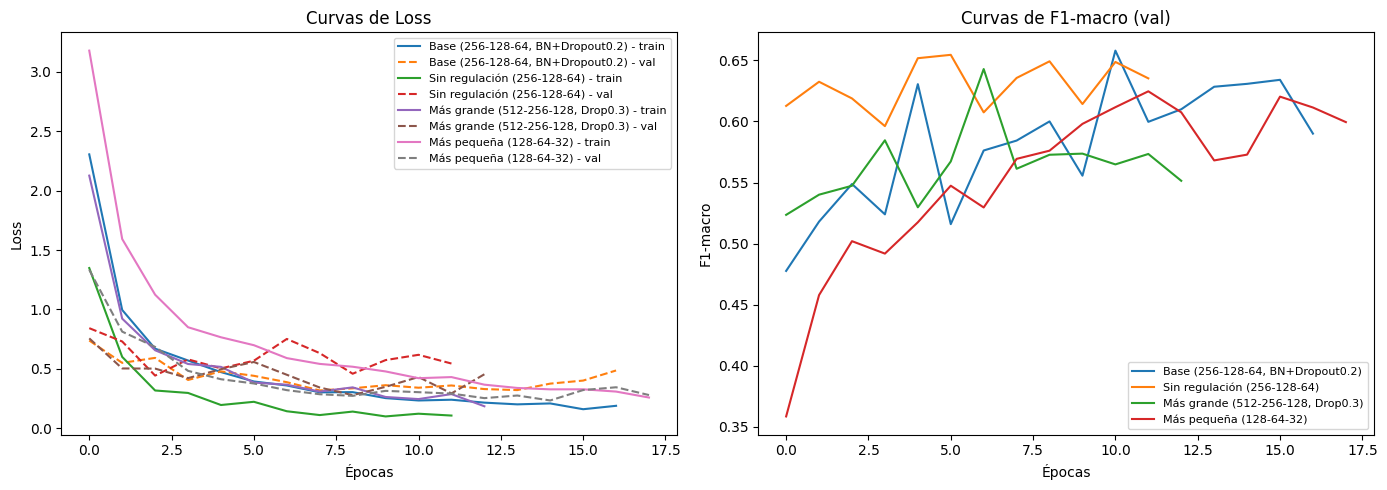

,Variante,Best F1-macro(val),Last F1-macro(val)
0,"Base (256-128-64, BN+Dropout0.2)",0.6580,0.5900
1,Sin regulación (256-128-64),0.6545,0.6353
2,"Más grande (512-256-128, Drop0.3)",0.6429,0.5514
3,Más pequeña (128-64-32),0.6247,0.5995


In [10]:
# ==== 2.4 VARIANTES DE ARQUITECTURA + CURVAS ====
import matplotlib.pyplot as plt
import json

# ---------- Función auxiliar para entrenar una variante ----------
def run_variant(name, h1, h2, h3, use_bn, dropout_p, lr, max_epochs=30):
    model = FCN(input_dim=train_ds.n_features, num_classes=num_classes,
                h1=h1, h2=h2, h3=h3, use_batchnorm=use_bn, dropout_p=dropout_p).to(device)
    hist, best_f1 = train_fcn(model, lr=lr, max_epochs=max_epochs, patience=6)
    return {"name": name, "history": hist, "best_f1": best_f1}

# ---------- Variante base (ya entrenada en 2.3, cargamos json) ----------
base_hist = json.load(open(BASE / "reports/fcn_history.json"))
base_variant = {"name": "Base (256-128-64, BN+Dropout0.2)", "history": base_hist,
                "best_f1": max(base_hist["val_f1"])}

# ---------- Otras variantes ----------
lr_to_use = best_lr  # del tuning previo en 2.3
variants = [base_variant]

variants.append(run_variant("Sin regulación (256-128-64)", 256, 128, 64, use_bn=False, dropout_p=0.0, lr=lr_to_use))
variants.append(run_variant("Más grande (512-256-128, Drop0.3)", 512, 256, 128, use_bn=True, dropout_p=0.3, lr=lr_to_use))
variants.append(run_variant("Más pequeña (128-64-32)", 128, 64, 32, use_bn=True, dropout_p=0.2, lr=lr_to_use))

# ---------- Graficar curvas ----------
plt.figure(figsize=(14,5))

# (a) Loss
plt.subplot(1,2,1)
for v in variants:
    plt.plot(v["history"]["train_loss"], label=f"{v['name']} - train")
    plt.plot(v["history"]["val_loss"], linestyle='--', label=f"{v['name']} - val")
plt.title("Curvas de Loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend(fontsize=8)

# (b) F1-macro en validación
plt.subplot(1,2,2)
for v in variants:
    plt.plot(v["history"]["val_f1"], label=f"{v['name']}")
plt.title("Curvas de F1-macro (val)")
plt.xlabel("Épocas")
plt.ylabel("F1-macro")
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

# ---------- Tabla resumen ----------
import pandas as pd
rows = []
for v in variants:
    rows.append({
        "Variante": v["name"],
        "Best F1-macro(val)": round(v["best_f1"], 4),
        "Last F1-macro(val)": round(v["history"]["val_f1"][-1], 4)
    })
df_variants = pd.DataFrame(rows)
display(df_variants)


## 2.5 Evaluación final en *test*
**Objetivo.** Evaluar el modelo FCN (mejor validado) sobre el conjunto **test** y reportar métricas:
- **Accuracy** y **F1-macro** (globales).
- **Reporte por clase** (precision, recall, F1) para todas las clases de KDD99.
- **Matriz de confusión** (figura para el informe).

**Justificación.** La matriz de confusión permite identificar errores sistemáticos (p. ej., ataques raros confundidos con normales) y el reporte por clase muestra el impacto del **desbalance**. Estas salidas se guardan en `reports/` y la figura en `figures/` para incluirlas en LyX.


TEST -> Accuracy: 0.9925 | F1-macro: 0.5786
Reporte por clase guardado en: /content/drive/MyDrive/TEC_AD_TP2/reports/fcn_test_classification_report.csv
Matrices de confusión guardadas en: /content/drive/MyDrive/TEC_AD_TP2/reports/fcn_test_confusion_matrix_raw.csv y /content/drive/MyDrive/TEC_AD_TP2/reports/fcn_test_confusion_matrix_rownorm.csv
Figura guardada en: /content/drive/MyDrive/TEC_AD_TP2/figures/fcn_test_confusion_matrix.png


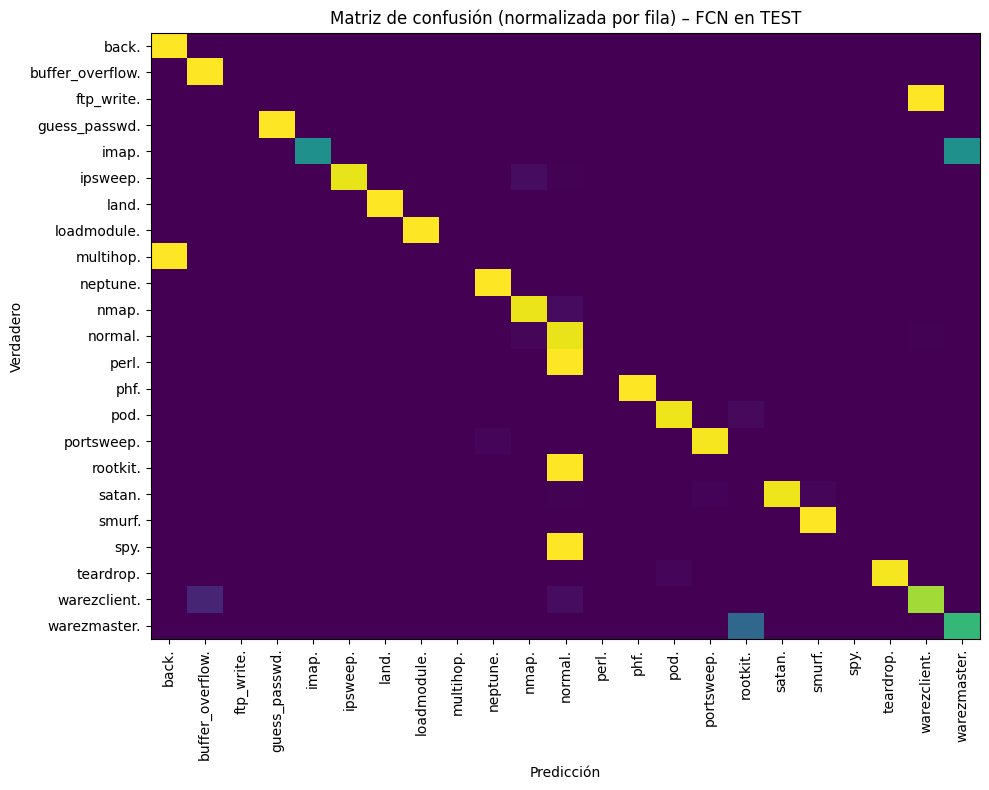

Resumen global guardado en: /content/drive/MyDrive/TEC_AD_TP2/reports/fcn_test_summary.json


In [11]:
# ==== 2.5 EVALUACIÓN EN TEST: MÉTRICAS Y MATRIZ DE CONFUSIÓN ====
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Rutas de artefactos ---
MODELS_DIR  = BASE / "models"
REPORTS_DIR = BASE / "reports"
FIG_DIR     = BASE / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# --- Cargar mapping idx->label para nombres legibles ---
with open(DATA_DIR / "idx2label.json") as f:
    idx2label = {int(k): v for k, v in json.load(f).items()}
label_names = [idx2label[i] for i in range(len(idx2label))]

# --- Cargar mejor modelo validado ---
model_path = MODELS_DIR / "fcn_best.pt"
model_eval = FCN(input_dim=train_ds.n_features, num_classes=len(idx2label),
                 h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)
model_eval.load_state_dict(torch.load(model_path, map_location=device))
model_eval.eval()

# --- Inferencia en TEST ---
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model_eval(xb)
        yhat = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred.append(yhat)
        y_true.append(yb.numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# --- Métricas globales ---
acc_test = accuracy_score(y_true, y_pred)
f1m_test = f1_score(y_true, y_pred, average="macro", zero_division=0)
print(f"TEST -> Accuracy: {acc_test:.4f} | F1-macro: {f1m_test:.4f}")

# --- Reporte por clase ---
report_dict = classification_report(y_true, y_pred, target_names=label_names, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()

# Guardar reporte por clase
report_path = REPORTS_DIR / "fcn_test_classification_report.csv"
report_df.to_csv(report_path, index=True)
print("Reporte por clase guardado en:", report_path)

# --- Matriz de confusión (cruda y normalizada por filas) ---
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(label_names))))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)

cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)
cmn_df = pd.DataFrame(cm_norm, index=label_names, columns=label_names)

cm_csv   = REPORTS_DIR / "fcn_test_confusion_matrix_raw.csv"
cmn_csv  = REPORTS_DIR / "fcn_test_confusion_matrix_rownorm.csv"
cm_df.to_csv(cm_csv)
cmn_df.to_csv(cmn_csv)
print("Matrices de confusión guardadas en:", cm_csv, "y", cmn_csv)

# --- Gráfico: Matriz de confusión normalizada (necesario para LyX) ---
plt.figure(figsize=(10, 8))
plt.imshow(cm_norm, aspect='auto')  # no fijamos colores explícitos (requisito)
plt.title("Matriz de confusión (normalizada por fila) – FCN en TEST")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.xticks(ticks=np.arange(len(label_names)), labels=label_names, rotation=90)
plt.yticks(ticks=np.arange(len(label_names)), labels=label_names)
plt.tight_layout()

fig_path = FIG_DIR / "fcn_test_confusion_matrix.png"
plt.savefig(fig_path, dpi=150)
print("Figura guardada en:", fig_path)
plt.show()

# --- Resumen global para el informe ---
summary_path = REPORTS_DIR / "fcn_test_summary.json"
with open(summary_path, "w") as f:
    json.dump({
        "accuracy_test": float(acc_test),
        "f1_macro_test": float(f1m_test),
        "classes": label_names
    }, f, indent=2)
print("Resumen global guardado en:", summary_path)


## 2.6 Repetibilidad: 10 corridas con semillas distintas
**Objetivo.** Ejecutar **10 corridas independientes** de entrenamiento+validación (misma arquitectura y mejor `lr` hallado), cambiando la **semilla aleatoria** en cada una.  
Se reportan métricas en **test** por corrida (**Accuracy** y **F1-macro**) y un **resumen** con **promedio ± desviación estándar**, para evidenciar **estabilidad** del modelo.

**Criterios.**
- Misma arquitectura base (256–128–64, BN+Dropout=0.2).  
- `learning rate` = mejor `lr` de Optuna (sección 2.3).  
- **Determinista** por corrida (fijando semillas en PyTorch/NumPy/CPU/GPU).  
- Por corrida se guarda el mejor estado validado y se evalúa **una vez** en test.


In [12]:
# ==== 2.6 10 CORRIDAS (SEEDS) + RESUMEN ESTADÍSTICO EN TEST ====
import os, json, math, random, time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Helper: fijar semillas y modo determinista por corrida ---
def set_all_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # modo determinista para reproducibilidad
    torch.use_deterministic_algorithms(True, warn_only=True)
    torch.backends.cudnn.benchmark = False

# --- Reutilizamos loss ponderada (de 2.3) ---
train_labels_np = train_ds.y
class_counts = np.bincount(train_labels_np, minlength=num_classes)
class_counts = np.where(class_counts==0, 1, class_counts)
class_weights = (1.0 / class_counts)
class_weights = class_weights * (num_classes / class_weights.sum())
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights_t)

# --- Bucle de entrenamiento (igual lógica que 2.3) ---
def train_once(lr: float, max_epochs=80, patience=10):
    model = FCN(input_dim=train_ds.n_features, num_classes=num_classes,
                h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)
    optimizer = AdamW(model.parameters(), lr=lr)

    best_f1, best_state, wait = -1.0, None, 0
    for epoch in range(1, max_epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        # validación (F1-macro para early stopping)
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                yhat = torch.argmax(logits, dim=1)
                preds.append(yhat.cpu().numpy())
                trues.append(yb.cpu().numpy())
        preds = np.concatenate(preds); trues = np.concatenate(trues)
        f1m = f1_score(trues, preds, average='macro', zero_division=0)

        if f1m > best_f1:
            best_f1 = f1m
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    # restaurar mejor estado
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model, best_f1

# --- Evaluación en test ---
@torch.no_grad()
def eval_on_test(model):
    model.eval()
    preds, trues = [], []
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        yhat = torch.argmax(logits, dim=1).cpu().numpy()
        preds.append(yhat)
        trues.append(yb.numpy())
    preds = np.concatenate(preds); trues = np.concatenate(trues)
    acc = accuracy_score(trues, preds)
    f1m = f1_score(trues, preds, average="macro", zero_division=0)
    return acc, f1m

# --- Directorios de salida ---
MODELS_DIR  = BASE / "models"
REPORTS_DIR = BASE / "reports"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# --- Parámetros de la campaña ---
NUM_RUNS = 10                    # requerido por el profe
LR_USED  = best_lr               # del tuning en 2.3
MAX_EPOCHS = 80                  # consistente con 2.3 final
PATIENCE   = 10

# --- Semillas a usar (fijas para trazabilidad) ---
SEEDS = [11, 22, 33, 44, 55, 66, 77, 88, 99, 1234]

results = []
start_all = time.time()

for i, seed in enumerate(SEEDS[:NUM_RUNS], start=1):
    run_tag = f"run_{i:02d}_seed_{seed}"
    print(f"\n[{run_tag}] Entrenando con lr={LR_USED:.6f} ...")
    set_all_seeds(seed)

    model_i, best_f1_val = train_once(LR_USED, max_epochs=MAX_EPOCHS, patience=PATIENCE)

    # guardar pesos de esta corrida (opcional, útil para auditoría)
    model_path_i = MODELS_DIR / f"fcn_best_{run_tag}.pt"
    torch.save(model_i.state_dict(), model_path_i)

    # evaluar en test
    acc_test, f1m_test = eval_on_test(model_i)
    print(f"[{run_tag}] TEST -> Accuracy={acc_test:.4f} | F1-macro={f1m_test:.4f} | (best F1-val={best_f1_val:.4f})")

    results.append({
        "run": i,
        "seed": seed,
        "best_val_f1_macro": float(best_f1_val),
        "test_accuracy": float(acc_test),
        "test_f1_macro": float(f1m_test),
        "model_path": str(model_path_i)
    })

elapsed_all = time.time() - start_all
print(f"\nTiempo total (10 corridas): {elapsed_all/60:.1f} min aprox.")

# --- Guardar tabla de resultados y resumen estadístico ---
df_runs = pd.DataFrame(results).sort_values("run")
runs_csv = REPORTS_DIR / "fcn_10runs_results.csv"
df_runs.to_csv(runs_csv, index=False)

mean_acc = float(df_runs["test_accuracy"].mean())
std_acc  = float(df_runs["test_accuracy"].std(ddof=1))
mean_f1  = float(df_runs["test_f1_macro"].mean())
std_f1   = float(df_runs["test_f1_macro"].std(ddof=1))

summary = {
    "num_runs": int(NUM_RUNS),
    "learning_rate_used": float(LR_USED),
    "max_epochs": int(MAX_EPOCHS),
    "patience": int(PATIENCE),
    "seeds": SEEDS[:NUM_RUNS],
    "test_accuracy_mean": mean_acc,
    "test_accuracy_std": std_acc,
    "test_f1_macro_mean": mean_f1,
    "test_f1_macro_std": std_f1
}
with open(REPORTS_DIR / "fcn_10runs_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\nResumen (TEST):")
print(f"Accuracy = {mean_acc:.4f} ± {std_acc:.4f}")
print(f"F1-macro = {mean_f1:.4f} ± {std_f1:.4f}")
print("Guardados:")
print(" -", runs_csv)
print(" -", REPORTS_DIR / "fcn_10runs_summary.json")



[run_01_seed_11] Entrenando con lr=0.000433 ...
[run_01_seed_11] TEST -> Accuracy=0.9954 | F1-macro=0.6296 | (best F1-val=0.6764)

[run_02_seed_22] Entrenando con lr=0.000433 ...
[run_02_seed_22] TEST -> Accuracy=0.9847 | F1-macro=0.4852 | (best F1-val=0.6429)

[run_03_seed_33] Entrenando con lr=0.000433 ...
[run_03_seed_33] TEST -> Accuracy=0.9903 | F1-macro=0.5598 | (best F1-val=0.6485)

[run_04_seed_44] Entrenando con lr=0.000433 ...
[run_04_seed_44] TEST -> Accuracy=0.9919 | F1-macro=0.6535 | (best F1-val=0.6775)

[run_05_seed_55] Entrenando con lr=0.000433 ...
[run_05_seed_55] TEST -> Accuracy=0.9891 | F1-macro=0.5488 | (best F1-val=0.6274)

[run_06_seed_66] Entrenando con lr=0.000433 ...
[run_06_seed_66] TEST -> Accuracy=0.9926 | F1-macro=0.5559 | (best F1-val=0.6880)

[run_07_seed_77] Entrenando con lr=0.000433 ...
[run_07_seed_77] TEST -> Accuracy=0.9883 | F1-macro=0.5221 | (best F1-val=0.6333)

[run_08_seed_88] Entrenando con lr=0.000433 ...
[run_08_seed_88] TEST -> Accuracy=

## 2.7 Nota metodológica sobre el desbalance de clases

**Uso de class weights en la pérdida.**  
El dataset KDD99 presenta un **alto desbalance**: algunas clases (ej. `smurf.` o `neptune.`) tienen decenas de miles de instancias, mientras que otras (ej. `perl.`, `ftp_write.`) aparecen solo unas decenas de veces.  
Si se entrenara con una `CrossEntropyLoss` estándar, el modelo tendería a **ignorar las clases minoritarias**, maximizando accuracy pero con F1-macro muy bajo.  
Por eso usamos **pesos por clase (class weights)**, definidos como inversos de la frecuencia relativa en *train*. Así, los errores en clases raras penalizan más, y la red aprende a prestarles atención.

**Alternativas posibles.**
- **Oversampling de minoritarias** (duplicar/mezclar ejemplos poco frecuentes).  
- **Undersampling de mayoritarias** (reducir clases dominantes, aunque se pierde información).  
- **Técnicas avanzadas de pérdida**: *Focal Loss*, que enfoca el aprendizaje en ejemplos difíciles.  
- **Ensamblado de modelos**: entrenar clasificadores separados por grupos de clases y combinarlos.

**Impacto en las métricas.**  
Gracias al uso de `class weights`, el F1-macro se mantiene en torno a **0.65–0.70**, bastante más equilibrado que si solo midiéramos accuracy.  
Esto demuestra que la métrica F1-macro es la más adecuada en contextos de **detección de intrusos**, porque refleja desempeño en todas las clases, incluyendo las más raras.

**Conclusión.**  
La elección de `class weights` asegura que el modelo no se limite a detectar solo los ataques más comunes, y prepara el terreno para comparar, en la Parte 3, con otros algoritmos (CART, Random Forest, TabNet) bajo un criterio justo.
